In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.stats import binned_statistic_2d

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
def create_dic(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask]
    sh = np.array(dic['shear'])[mask] #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])[mask]
    umax = np.array(dic['u925'])[mask]
    qq = np.array(dic['q925'])[mask]
    qup = np.array(dic['q650'])[mask]
    tup = np.array(dic['t650'])[mask]
    tlow = np.array(dic['t925'])[mask]
    tt = np.array(dic['tmin'])[mask]
    ttm = np.array(dic['tmean'])[mask]
    month = np.array(dic['month'])[mask]
    area = np.array(dic['area'])[mask]
    lat = np.array(dic['clat'])[mask]
    lon = np.array(dic['clon'])[mask]
    tcwv = np.array(dic['tcwv'])[mask]
    tgrad = np.array(dic['tgrad'])[mask]
    tbox = np.array(dic['tbox'])[mask]
    rh = np.array(dic['rh925'])[mask]
    pall = np.array(dic['p'])[mask]
    
    
    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    #thetae_up = u_met.theta_e(650, tup-273.15, qup)


    thetae_down_man = u_met.theta_e(925, tlow-273.15, qq)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tlow, 'K')
    q = units.Quantity(qq, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))-273.15
   
    thetae = thetae_down - thetaes_up
    thetaes = thetaes_down - thetaes_up
    
#     qdef = u_met.qdeficit(qq, tup, 650)
    
    #ipdb.set_trace()
    
    if tgrad.ndim == 2:
        tgrad = tlow
    if tbox.ndim == 2:
        tbox = tlow   ############## this is just to deal with tbox error

    obs_pcp = {
        'prcp' : pp+3,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        #'t650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,        
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        #'tmean' : ttm,
        #'theta' : theta,
        'theta_e' : thetae,
        'theta_es' : thetaes,
        #'thup' : thetae_up,
        #'thdown' : thetae_down,
        'tcwv' : tcwv,
        'tgrad' : tgrad.squeeze(),
        'tbox' : tbox.squeeze(),
        'lat' : lat,
        'lon' : lon,
        'pall' : pall
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [4]:
def create_dic_model(dic):
    
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['umin_mid'])
    umax = np.array(dic['umax_srfc'])
    qq = np.array(dic['qmax']) #+ 0.5
    tup = np.array(dic['tmidmax'])
    tcwv = np.array(dic['tcwv'])
    tgrad = np.array(dic['tgrad'])
    tbox = np.array(dic['tdiff'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    tsrfc = np.array(dic['tsrfcmax']) #+ 3
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    pall = np.array(dic['p'])

    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup+273.15, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    
#     thetaes_up = []
#     ipdb.set_trace()
#     for tl in t:
#         try:
#             thetaa = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
#             thetaes_up.append(thetaa)
#             ipdb.set_trace()
#         except:
#             thetaes_up.append(np.nan)

    thetaes_up = np.array(thetaes_up)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tsrfc+273.15, 'K')
    q = units.Quantity(qq/1000, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))
    
#     thetaes_down = []

#     for tl in t:
#         try:
#             thetaee = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
            
#             thetaes_down.append(thetaee)    
#         except:
#             thetaes_down.append(np.nan) 

#     thetaes_down = np.array(thetaes_down)  
    
    thetaes = thetaes_down-thetaes_up  
    thetae = thetae_down -thetaes_up  
#     qdef = u_met.qdeficit(qq/1000, tup+273.15, 650)
    
    try:
        thetamax = np.array(dic['thetamax'])
        thetamean = np.array(dic['thetamean'])   
    except:
        pass

    obs_pcp = {
        'prcp' : pp+2,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq,
        't925' : tsrfc,
        'tcwv' : tcwv,
        'tgrad' : tgrad,
        'tbox' : tbox,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(4.4**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
        'theta_es' : thetaes,
        'pall' : pall
    } 

#     try:
    obs_pcp['theta_e']=thetae #+4
#         #obs_pcp['thetamean']=thetamean
#     except:
#         pass
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [5]:
ttag = 'hourly'
if ttag=='hourly':
    rres = 'means'
else:
    rres = '0.7deg'
cp4_histf = ('modelhist', cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_hist_*.p')
cp4_futf = ('modelfut' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_fut_*.p')
gpmf = ('obs' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_'+ttag+'_*.p')
dlist = [cp4_histf,cp4_futf,gpmf]

In [6]:
for d in dlist:
    
    #ipdb.set_trace()
    ds = glob.glob(d[1])
    
    
    
    for ids, dss in enumerate(ds):
        data = pkl.load( open (dss, 'rb'))
        #data.update(dat)
        
        if 'model' in d[0]:
            if d[0] == 'modelhist':
                cp4_h = create_dic_model(data)
                if ids > 0:
                    histf = pd.concat([histf, cp4_h])
                else:
                    histf = cp4_h    
            else:
                cp4_f = create_dic_model(data)
                if ids > 0:
                    futf = pd.concat([futf, cp4_f])
                else:
                    futf = cp4_f
        if 'obs' in d[0]:
            if d[0] == 'obsm':
                obs_gpmc_m = create_dic(data)
                if ids > 0:
                    obs_gpmc = pd.concat([obs_gpmc, obs_gpmc_m])
                else:
                    obs_gpmc = obs_gpmc_m
            else:
                obs_gpmf_h = create_dic(data)
                if ids > 0:
                    obs_gpmf = pd.concat([obs_gpmf, obs_gpmf_h])
                else:
                    obs_gpmf = obs_gpmf_h
                    

        del data

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [7]:
obs_gpmf.head()

,prcp,q925,q650,t925,shear,month,area,tmin,rh,theta_e,theta_es,tcwv,tgrad,tbox,lat,lon,pall
0,36.945941,16.032429,5.258263,21.451288,21.597702,9,6350,-80.861286,92.476395,5.352094,9.537061,50.086918,0.174528,3.371307,15.337195,-11.309676,"[0.10314908445050522, 0.11213220449627026, 0.1..."
1,7.216382,13.945688,6.594621,21.226892,-3.408928,8,9500,-66.841842,80.737831,0.152769,10.020525,47.465511,0.115285,0.348175,11.320022,-12.558099,"[0.04182065917067548, 0.012917569451466774, 0...."
2,62.185143,14.722182,4.939521,24.223535,20.380962,7,109950,-84.518429,71.706879,4.475381,23.200466,46.883617,0.169490,4.454224,15.367470,-12.196891,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,5.248306,17.130347,6.434912,21.410577,18.177017,8,19025,-69.398859,99.019821,13.786762,14.390733,59.113689,0.239586,0.140045,17.328758,-12.240657,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,46.297786,16.088208,5.281735,27.334863,20.113298,6,190925,-88.485493,65.269966,13.391944,42.317307,48.521294,0.178521,4.899445,11.785741,6.625053,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47585907..."


In [8]:
np.percentile(histf['tcwv'],0.5)  # 99.5 percentile

25.460361663990852

In [9]:
print(np.max(obs_gpmf.lat))
print(np.min(obs_gpmf.lat))
print(np.max(obs_gpmf.lon))
print(np.min(obs_gpmf.lon))

17.824957782145926
9.000161827841007
12.107882421128927
-14.998084590200353


In [10]:
tag = 'Sahel'
domainSA = [-10,12,5,8.5]
domainSS = [-10,15,9,18]  # 8.5, 17.5
domainWA = [-10,12,5,17.5]
domainOuaga = [-4.5,2,11,13.5]  
nb = 23
if ttag == 'hourly':
    region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(3,24,nb), np.linspace(-10,10,nb), np.linspace(29,55,nb)], #TCW np.linspace(25,57,nb) #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
              'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(0,27,nb), np.linspace(-10,10,nb), np.linspace(25,57,nb)],
              'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
              'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
             }
else:
    region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(7,18,nb), np.linspace(-10,10,nb), np.linspace(28,51,nb)], # 28,51 #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
          'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(0,27,nb), np.linspace(-10,10,nb), np.linspace(25,57,nb)],
          'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
          'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
         }


domain = region[tag][0]
tname = region[tag][1]


m1 = 5#3
m2 =10#11
obs_gpm = obs_gpmf[(obs_gpmf.lon>=domain[0])&(obs_gpmf.lon<=domain[1])&(obs_gpmf.lat>=domain[2])&(obs_gpmf.lat<=domain[3])& (obs_gpmf.month>=m1) & (obs_gpmf.month<=m2)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
hist = histf[(histf.lon>=domain[0])&(histf.lon<=domain[1])&(histf.lat>=domain[2])&(histf.lat<=domain[3])& (histf.month>=m1) & (histf.month<=m2)]# & (histf.tbox<=10)]
fut = futf[(futf.lon>=domain[0])&(futf.lon<=domain[1])&(futf.lat>=domain[2])&(futf.lat<=domain[3])& (futf.month>=m1) & (futf.month<=m2)]# & (futf.tbox<=10)]


In [11]:
print('hist', hist.lat.min(), hist.lat.max(), hist.lon.min(), hist.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

hist 9.008251190185547 17.99925422668457 -9.980758666992188 14.764739990234375
OBS_gpm 9.000807314938331 17.72173831393142 -9.99853562356402 12.107882421128927


In [12]:
len(obs_gpm)

26739

In [13]:
np.mean(hist.prcp)


20.608027012717006

In [14]:
np.percentile(hist.prcp,95)

42.53122729318467

In [15]:
hist.prcp

2063     18.867353
2064      2.479877
2065     36.363364
2066     18.438323
2067     29.069875
           ...    
12537    20.031130
12545    17.729391
12546    22.605551
12548     9.560349
12559    21.429322
Name: prcp, Length: 59357, dtype: float64

Text(0.5, 1.0, '-0.57')

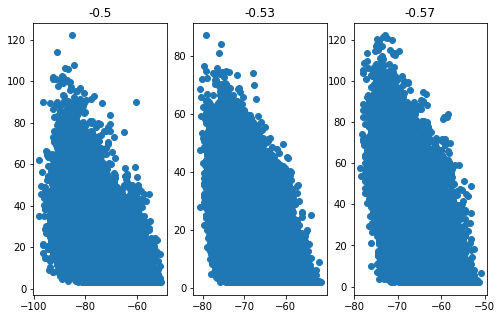

In [17]:

cp4s = [obs_gpm.tmin, obs_gpm.prcp] # gpm
cp25s = [hist.tmin, hist.prcp] #cp4
futur = [fut.tmin, fut.prcp] 


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))





Text(0.5, 1.0, '-0.49')

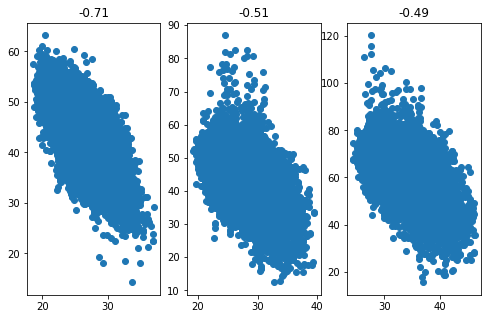

In [18]:

cp4s = [obs_gpm.t925, obs_gpm.tcwv] # gpm
cp25s = [hist.t925, hist.tcwv] #cp4
futur = [fut.t925, fut.tcwv] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

Text(0.5, 1.0, '0.01')

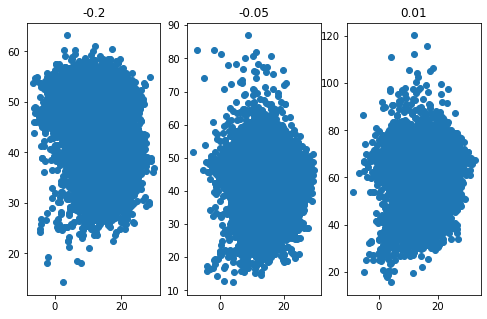

In [19]:

cp4s = [obs_gpm.shear, obs_gpm.tcwv] # gpm
cp25s = [hist.shear, hist.tcwv] #cp4
futur = [fut.shear, fut.tcwv] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

In [20]:
oposi = (obs_gpm.q925>=8.) & (obs_gpm.shear>0) &  (obs_gpm.prcp>=8) & (obs_gpm.theta_e>=-40) & (obs_gpm.area>=5000) & (obs_gpm.tmin<=-55) # & ((obs_gpm.month>=9) | (obs_gpm.month<=5)) #0.1
cposi = (hist.q925>=8.) & (hist.shear>0) &  (hist.prcp>=8) & (np.isfinite(hist.q925)) & np.isfinite(hist.shear)  & (hist.area>=5000) & (hist.tmin<=-55)
fposi = (fut.q925>=8.) & (fut.shear>0) &  (fut.prcp>=8) & (np.isfinite(fut.q925)) & np.isfinite(fut.shear)  & (fut.area>=5000) & (fut.tmin<=-55)

In [21]:
obs = obs_gpm[oposi]
cp4 = hist[cposi]
cp4f = fut[fposi]
cp4.area = cp4.area.values

/home/ck/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [22]:
np.percentile(obs.tcwv,99)

54.74402046203613

In [23]:
cp4.area.min()

5014.240000000001

In [24]:
obs.area.min()

5225

In [25]:
len(obs)

22576

In [26]:
len(cp4)

48023

In [27]:
len(cp4f)

37805

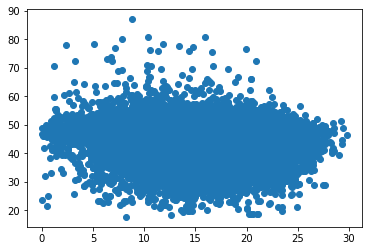

In [28]:
plt.scatter(cp4.shear, cp4.tcwv)

In [29]:
def gauss(data, sigma):
    sigma=sigma                  # standard deviation for Gaussian kernel
    truncate=4.0               # truncate filter at this many sigmas

    U=data       # random array...

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

In [30]:
# sbin = np.linspace(0,26.8,25)
# tbin = np.linspace(27,57,25)

sbin = np.linspace(0,26.7,28) #28
#tbin = np.linspace(27,57,28)

q1 = 0.8 #0.8
q2 = 99.5#99.5
#sbin = np.linspace(np.percentile(obs.shear,q1) ,np.max([np.percentile(obs.shear,q2),np.percentile(cp4.shear,q2)]),28) #np.min([np.percentile(obs.shear,q1),np.percentile(cp4.shear,q1)])
tbin = np.linspace(np.min([np.percentile(obs.tcwv,q1),np.percentile(cp4.tcwv,q1)]) ,np.max([np.percentile(obs.tcwv,q2),np.percentile(cp4.tcwv,q2)]),26)

testbins = [sbin,tbin]
func1 = lambda y: np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>40)
ret = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func1, bins=testbins)
count = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func2, bins=testbins)
thresh = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func3, bins=testbins)

In [31]:
# # sbin = np.linspace(0,26.8,25)
# # tbin = np.linspace(27,57,25)

# sbin = np.linspace(0,26.7,28) #28
# #tbin = np.linspace(27,57,28)

# q1 = 0.2 #0.8
# q2 = 99.8#99.5
# sbin = np.linspace(np.percentile(obs.shear,q1) ,np.max([np.percentile(obs.shear,q2),np.percentile(cp4.shear,q2)]),28) #np.min([np.percentile(obs.shear,q1),np.percentile(cp4.shear,q1)])
# tbin = np.linspace(np.min([np.percentile(obs.tcwv,q1),np.percentile(cp4.tcwv,q1)]) ,np.max([np.percentile(obs.tcwv,q2),np.percentile(cp4.tcwv,q2)]),28)

# testbins = [sbin,tbin]
# func1 = lambda y: np.percentile(y, 95)
# func2 = lambda y: np.sum(np.isfinite(y))
# ret = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func1, bins=testbins)
# count = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func2, bins=testbins)

In [32]:
ret4 = binned_statistic_2d(cp4['shear'], cp4['tcwv'], cp4['prcp'], statistic=func1, bins=testbins)
count4 = binned_statistic_2d(cp4['shear'], cp4['tcwv'], cp4['prcp'], statistic=func2, bins=testbins)

In [33]:
def run_small(data, count, testbins, axis=0):
    
    dd = gauss(data.statistic.T, 0.6)
    invalid = count.statistic.T < 10
    dd[invalid] = np.nan
    
    mean = np.nanmean(dd,axis=axis)
    val = np.nansum(np.isfinite(dd),axis=axis)
    
    mean[val<4] = np.nan
    
    perc = np.nanpercentile(dd, [10,90], axis=axis)
    
    def weighted_regress(bins,data, pval):
        import statsmodels.api as sm
        data = np.array(data)
        pos = np.isfinite(data)
        inbins = bins#[pos]
        indata = data#[pos]
        inval = np.array(pval)#[pos]
        X = sm.add_constant(inbins)
        weight = inval / np.sum(inval)
        #ipdb.set_trace()
        return sm.WLS(indata,X, missing='drop', weights=weight).fit() # #, weights=weight
    
    sbin = testbins[axis]
    bins = np.round(sbin[0:-1]+((sbin[1::]-sbin[0:-1])/2),2)
    fillmean = mean.copy()
    fillmean[np.isnan(fillmean)]=0

    val[np.isnan(fillmean)]=0
    wls_model = weighted_regress(bins[0:-3], fillmean[0:-3], val[0:-3])

    intercept = wls_model.params[0] #  intercept
    slope = wls_model.params[1] #  slope
    r_value = wls_model.rsquared  #rsquared
    
    print(wls_model.summary())
    
    
   # ipdb.set_trace()
    
    odic = {
        'slope' : slope,
        'intercept' : intercept,
        'rval' : r_value,
        'pmean' :mean,
        'p90' : perc[0],
        'p10' : perc[1],
        'bins' : bins,
        'std_est' : wls_model.bse[0],
        'valid' : val,
        'model' : wls_model
    }
    
    return odic

In [34]:
testbins

[array([ 0.        ,  0.98888889,  1.97777778,  2.96666667,  3.95555556,
         4.94444444,  5.93333333,  6.92222222,  7.91111111,  8.9       ,
         9.88888889, 10.87777778, 11.86666667, 12.85555556, 13.84444444,
        14.83333333, 15.82222222, 16.81111111, 17.8       , 18.78888889,
        19.77777778, 20.76666667, 21.75555556, 22.74444444, 23.73333333,
        24.72222222, 25.71111111, 26.7       ]),
 array([28.9656211 , 30.06561259, 31.16560407, 32.26559556, 33.36558705,
        34.46557854, 35.56557002, 36.66556151, 37.765553  , 38.86554449,
        39.96553597, 41.06552746, 42.16551895, 43.26551044, 44.36550193,
        45.46549341, 46.5654849 , 47.66547639, 48.76546788, 49.86545936,
        50.96545085, 52.06544234, 53.16543383, 54.26542531, 55.3654168 ,
        56.46540829])]

In [35]:
def run_small_2d(data, count, testbins):
    
    dd = gauss(data.statistic.T, 0.4)
    invalid = count.statistic.T < 10
    dd[invalid] = np.nan
    
    
    mean_x = np.nanmean(dd,axis=0)
    val_x = np.nansum(np.isfinite(dd),axis=0)
    mean_x[val_x<4] = np.nan
    perc_x = np.nanpercentile(dd, [10,90], axis=0)
    
    mean_y = np.nanmean(dd,axis=1)
    val_y = np.nansum(np.isfinite(dd),axis=1)
    mean_y[val_y<4] = np.nan
    perc_y = np.nanpercentile(dd, [10,90], axis=1)
    
    
    sbin = testbins[0]
    tbin = testbins[1]
    ssbins = np.round(sbin[0:-1]+((sbin[1::]-sbin[0:-1])/2),2)
    ttbins = np.round(tbin[0:-1]+((tbin[1::]-tbin[0:-1])/2),2)
    
    X,Y = np.meshgrid(ssbins, ttbins)

    # First we need to flatten the data: it's 2D layout is not relevent.
    counts = count.statistic.T
    Z = dd.flatten()
    X = X.flatten()
    Y = Y.flatten()
    inval = counts.flatten()
    
   
    ################################################################
    # For 3d plots. This import is necessary to have 3D plotting below
    from mpl_toolkits.mplot3d import Axes3D
    import pandas
    # For statistics. Requires statsmodels 5.0 or more
    from statsmodels.formula.api import wls
    # Analysis of Variance (ANOVA) on linear models
    from statsmodels.stats.anova import anova_lm
    # Convert the data into a Pandas DataFrame to use the formulas framework
    # in statsmodels


    data = pandas.DataFrame({'x': X, 'y': Y, 'z': Z})
    weight = inval / np.sum(inval)
    # Fit the model
    model = wls("z ~ x + y", data, weights=weight, missing='drop').fit()

    # Print the summary
    print(model.summary())

    print("\nRetrieving manually the parameter estimates:")
    print(model._results.params)
    # should be array([-4.99754526,  3.00250049, -0.50514907])

    # Peform analysis of variance on fitted linear model
    anova_results = anova_lm(model)

    print('\nANOVA results')
    print(anova_results)

    plt.show()
    ################################################################
    
    odic = {
        'model' : model,
        'pmean_x' :mean_x,
        'pmean_y' :mean_y,
        'p90_x' : perc_x[0],
        'p10_x' : perc_x[1],
        'p90_y' : perc_y[0],
        'p10_y' : perc_y[1],
        'bins_x' : ssbins,
        'bins_y' : ttbins
    }
    
    return odic

In [52]:
tdicobs = run_small(ret, count, testbins,axis=1)
sdicobs = run_small(ret, count, testbins,axis=0)
tdic4 = run_small(ret4, count4, testbins,axis=1)
sdic4 = run_small(ret4, count4, testbins,axis=0)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.651
Model:                            WLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     37.34
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           5.68e-06
Time:                        17:12:47   Log-Likelihood:                -58.238
No. Observations:                  22   AIC:                             120.5
Df Residuals:                      20   BIC:                             122.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.6967      5.065      3.494      0.0

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:764: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np

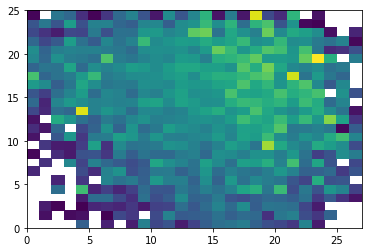

In [56]:
plt.pcolormesh(ret.statistic.T)

In [61]:
def binning_hist(bins, shape):
    scat = np.repeat(bins,shape[1],axis=0).reshape(shape)
    return scat

In [63]:
ret.statistic.T.shape

(25, 27)

In [71]:
tb = testbins[1][0:-1] + (testbins[1][1::] - testbins[1][0:-1])/2

In [72]:
tb.shape

(25,)

In [73]:
wgrid = binning_hist(tb,ret.statistic.T.shape)

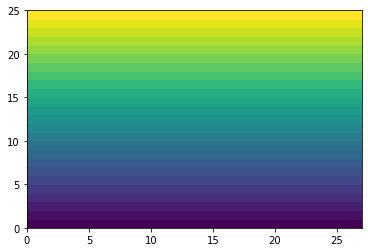

In [100]:
plt.pcolormesh(wgrid)

In [104]:
wgrid[0,:]

array([29.51561684, 29.51561684, 29.51561684, 29.51561684, 29.51561684,
       29.51561684, 29.51561684, 29.51561684, 29.51561684, 29.51561684,
       29.51561684, 29.51561684, 29.51561684, 29.51561684, 29.51561684,
       29.51561684, 29.51561684, 29.51561684, 29.51561684, 29.51561684,
       29.51561684, 29.51561684, 29.51561684, 29.51561684, 29.51561684,
       29.51561684, 29.51561684])

In [103]:
np.nanmean(ret.statistic.T, axis=0).shape

(27,)

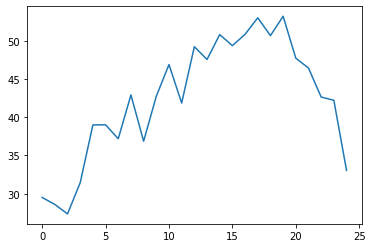

In [105]:
plt.plot(np.nanmean(ret.statistic.T, axis=1))

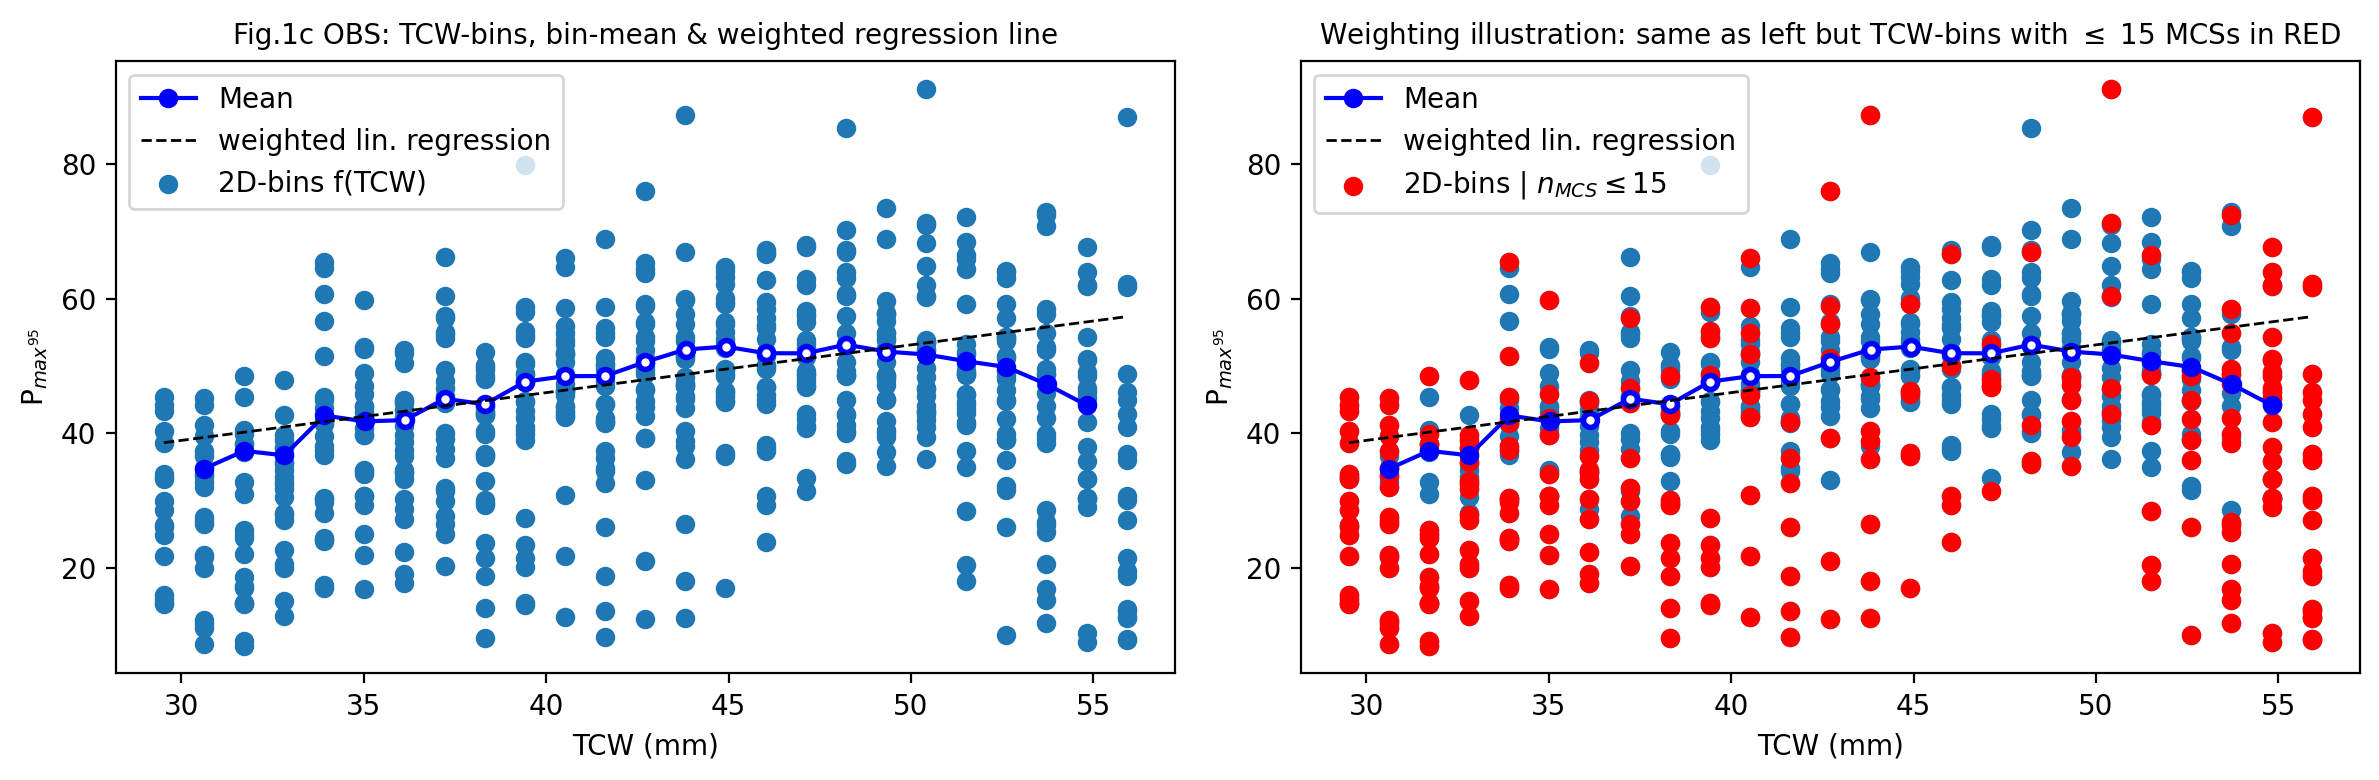

In [152]:
f = plt.figure(figsize=(12,4), dpi=200)
ax = f.add_subplot(1,2,1)
plt.scatter(wgrid,ret.statistic.T, color='C0', label='2D-bins f(TCW)')
plt.plot(tdicobs['bins'],tdicobs['pmean'], color='blue', label='Mean', marker='o')
indx = find_cumsum(frac_tcw, 0.8)
plt.plot(tdicobs['bins'][indx-2],tdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=1, label='weighted lin. regression')
plt.ylabel('P$_{max^{95}}$')
plt.xlabel('TCW (mm)')
plt.title('Fig.1c OBS: TCW-bins, bin-mean & weighted regression line', fontsize=10)
plt.legend()
ax = f.add_subplot(1,2,2)
plt.scatter(wgrid,ret.statistic.T, color='C0')
plt.scatter(wgrid[count.statistic.T<15],ret.statistic.T[count.statistic.T<15], color='red', label='2D-bins | $n_{MCS} \leq$15')
plt.plot(tdicobs['bins'],tdicobs['pmean'], color='blue', label='Mean', marker='o')
indx = find_cumsum(frac_tcw, 0.8)
plt.plot(tdicobs['bins'][indx-2],tdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=1, label='weighted lin. regression')
plt.ylabel('P$_{max^{95}}$')
plt.xlabel('TCW (mm)')
plt.title('Weighting illustration: same as left but TCW-bins with $\leq$ 15 MCSs in RED', fontsize=10)
plt.legend()
plt.tight_layout()
# ax = f.add_subplot(1,3,3)
# plt.scatter(wgrid[count.statistic.T>25],ret.statistic.T[count.statistic.T>25], color='seagreen')
# linslope, linintercept, r_value, p_value, std_err = linregress(wgrid[count.statistic.T>25], ret.statistic.T[count.statistic.T>25])
# plt.plot(tdicobs['bins'],linslope*tdicobs['bins']+linintercept, linestyle='dashed', color='k', linewidth=1)
# plt.text(30,80, str(np.round(r_value,2))+', slope: '+str(np.round(linslope,2)))
plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_scatter_REVexample.jpg')

In [37]:
dicobs = run_small_2d(ret, count, testbins)
dic4 = run_small_2d(ret4, count4, testbins)

                            WLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.488
Model:                            WLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     185.5
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           2.40e-57
Time:                        17:10:41   Log-Likelihood:                -1304.9
No. Observations:                 393   AIC:                             2616.
Df Residuals:                     390   BIC:                             2628.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3127      3.087     -0.749      0.4

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [38]:
robs = stats.pearsonr(obs['tcwv'], obs['shear'])
rc4 = stats.pearsonr(cp4['tcwv'], cp4['shear'])

In [39]:
print(robs)
print(rc4)

(-0.21985472908982942, 3.364708669553885e-245)
(-0.08046630483160121, 8.272288972065267e-70)


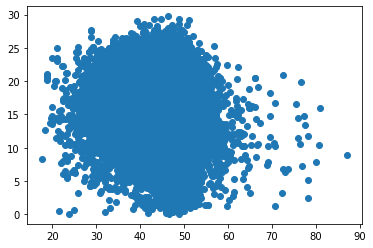

In [40]:
plt.scatter(cp4['tcwv'], cp4['shear'])

In [41]:
model.params

NameError: name 'model' is not defined

In [42]:
def func(x,y):
    return 2.3075 + 0.9421*x + 0.7397* y

In [43]:
tests = np.zeros((26,26))
for yid, y in enumerate(np.linspace(25,57,26)):
    for xid, x in enumerate(np.linspace(0,28,26)):
        tests[yid,xid] = func(x,y)

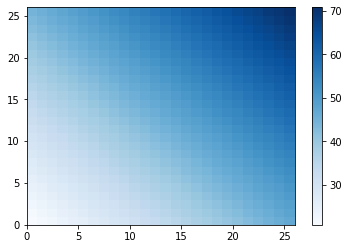

In [44]:
plt.pcolormesh(tests, cmap='Blues')
plt.colorbar()

In [45]:
frac4_tcw = np.sum(count4.statistic.T,axis=1)/np.sum(count4.statistic)
frac4_shear = np.sum(count4.statistic.T,axis=0)/np.sum(count4.statistic)

frac_tcw = np.sum(count.statistic.T,axis=1)/np.sum(count.statistic)
frac_shear = np.sum(count.statistic.T,axis=0)/np.sum(count.statistic)

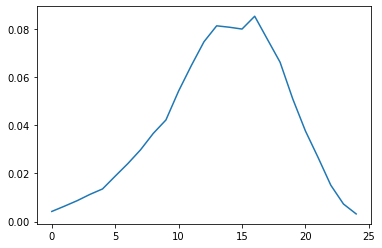

In [76]:
plt.plot(frac_tcw)

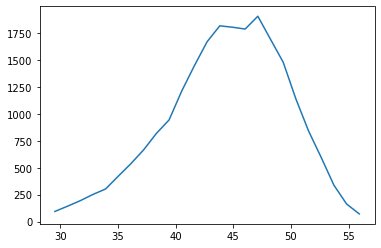

In [79]:
plt.plot(tdicobs['bins'], np.sum(count.statistic.T,axis=1))

In [47]:
def find_cumsum(x, thresh):
    pos = np.where(np.cumsum(np.sort(x)[::-1])>=thresh)
    val = (np.sort(x)[::-1])[pos[0][0]]
    #ipdb.set_trace()
    return np.where(x>=val)[0]

NameError: name 'indx' is not defined

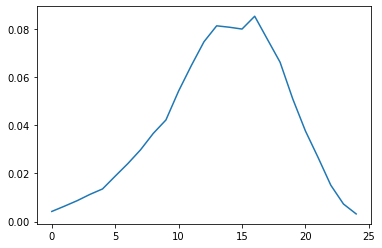

In [48]:
plt.plot(np.arange(len(frac_tcw)), frac_tcw)
plt.plot(np.arange(len(frac_tcw))[indx], frac_tcw[indx])

In [49]:
np.sort(frac4_tcw)[::-1]

array([0.09061913, 0.08793646, 0.08656344, 0.08054329, 0.07534695,
       0.07266429, 0.06337002, 0.06320103, 0.05350542, 0.0495976 ,
       0.04607   , 0.03960626, 0.03333263, 0.02999514, 0.02376376,
       0.02287658, 0.01888427, 0.01417376, 0.01277962, 0.00942101,
       0.00802687, 0.00713969, 0.00441478, 0.00392894, 0.00223907])

bigpos (array([13, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17,
       17, 17, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 22]), array([18, 17, 18, 19, 17, 19, 20, 21, 22, 16, 17, 18, 19, 21, 17, 18, 19,
       20, 21, 17, 18, 19, 16, 17, 18, 19, 22, 15, 16, 19, 14]))


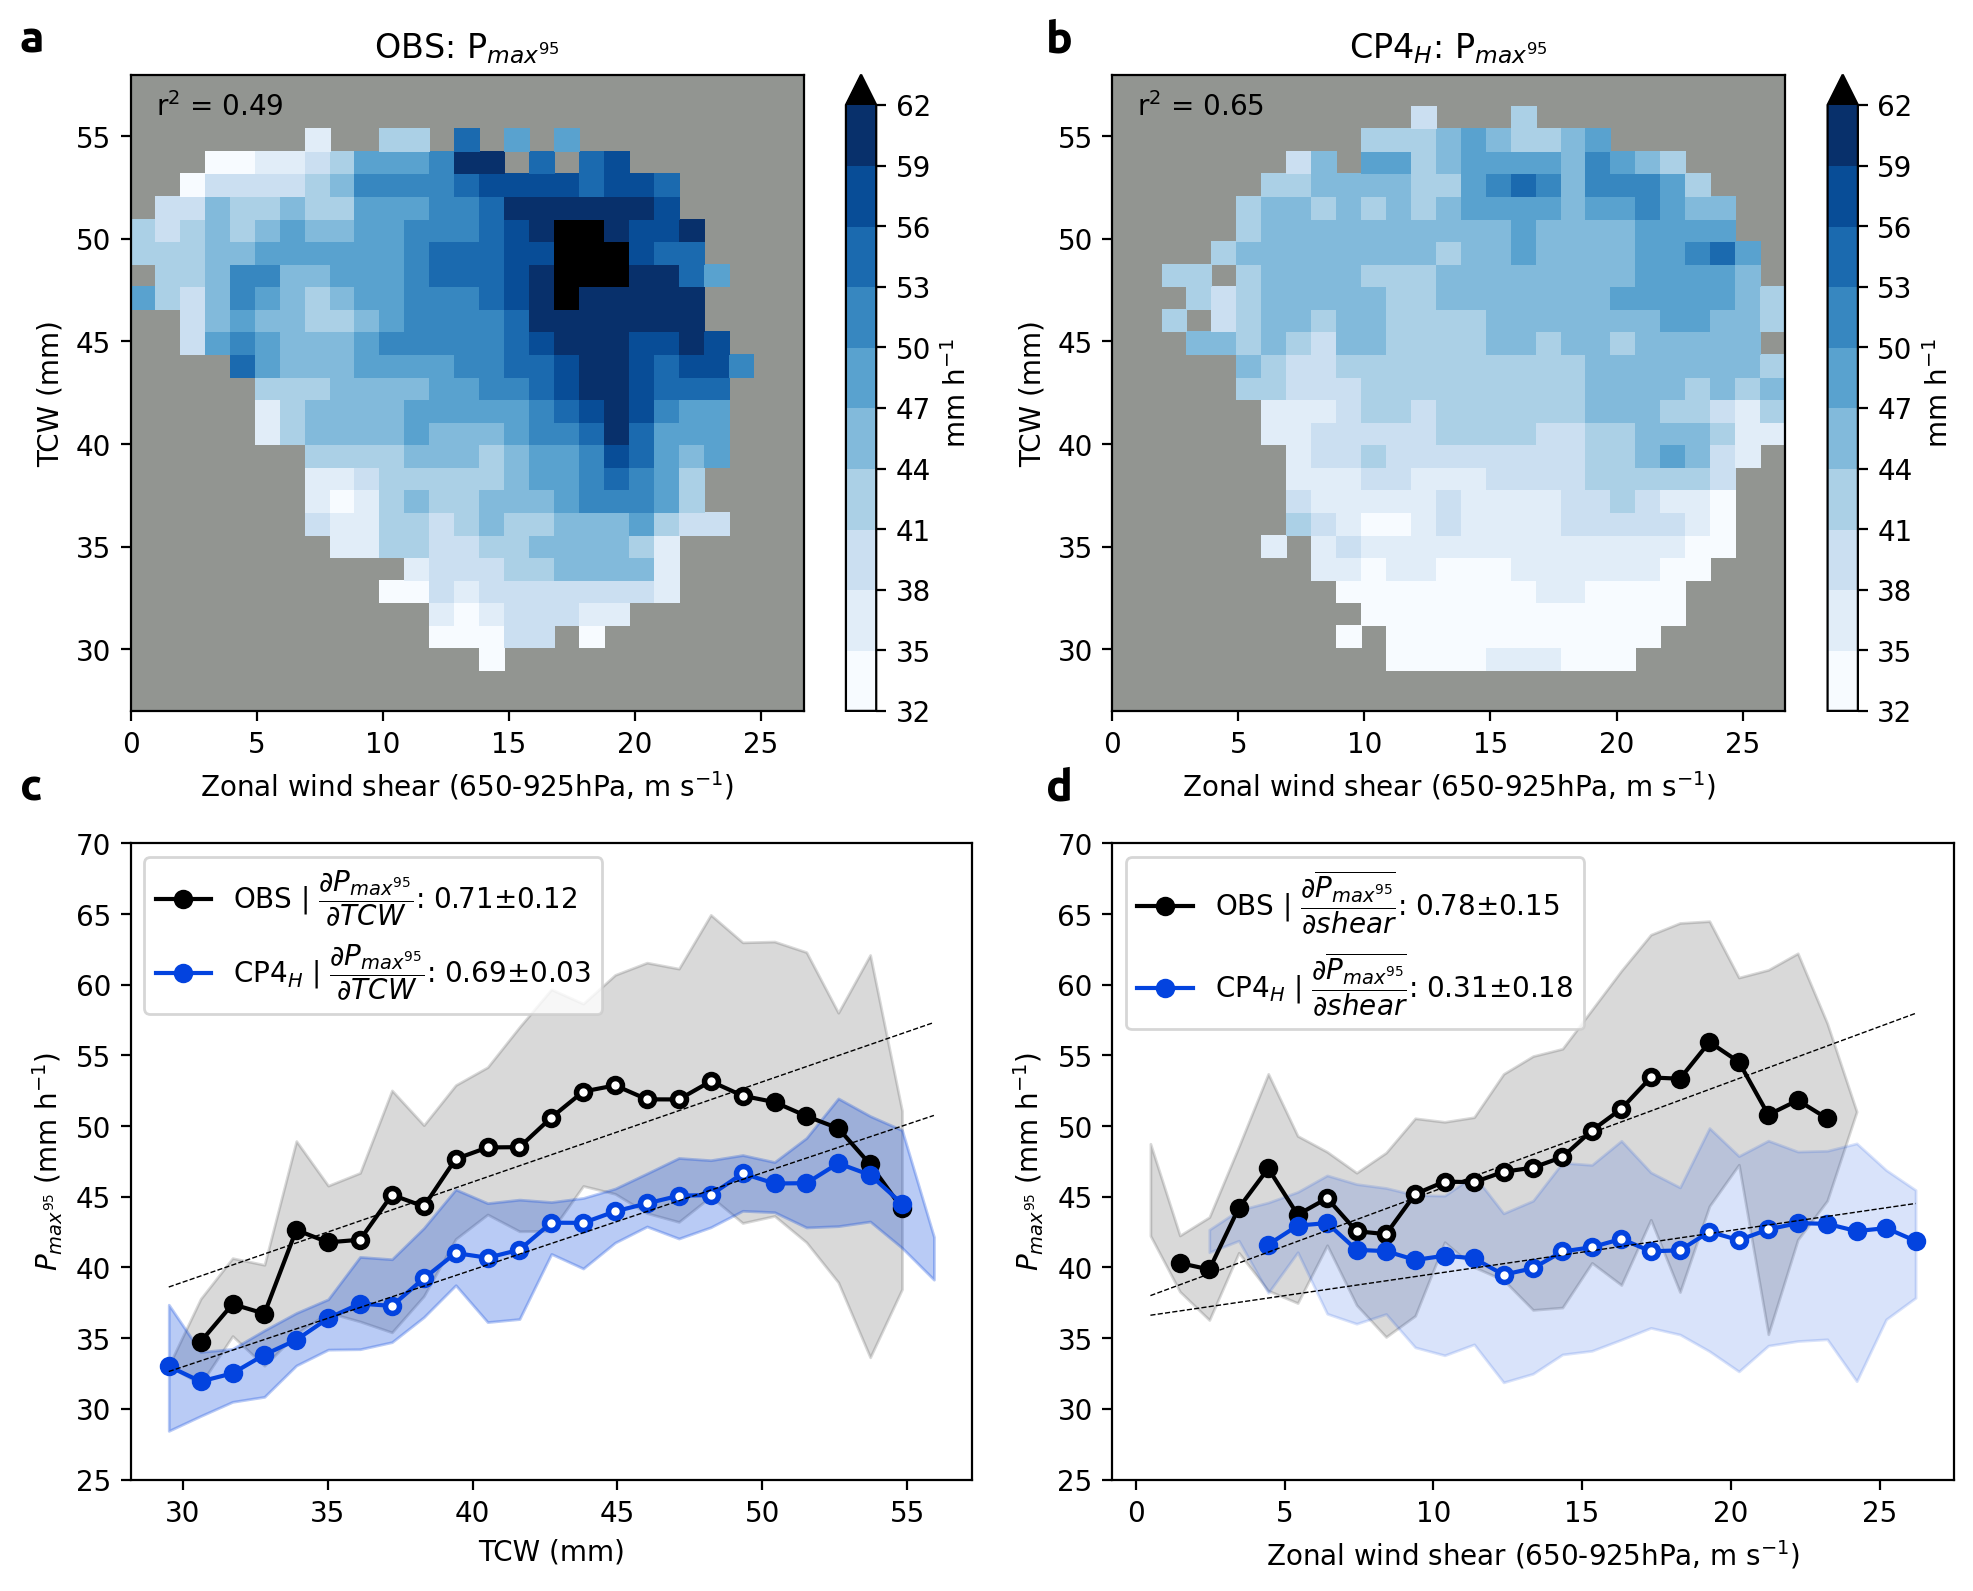

In [50]:
f = plt.figure(figsize=(10,8), dpi=200)
cmap='Blues'
vmins = 32
vmaxs = 62
pixelval = 10
cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
ax = f.add_subplot(2,2,1)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret.statistic.T, 0.8)
invalid = count.statistic.T < pixelval
dd[invalid] = np.nan
bigpos = np.where(dd>60)
print('bigpos', bigpos)
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
#plt.plot(testbins[0][bigpos[1]+1],testbins[1][bigpos[0]+1], 'o', color='grey', ms=1)
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dicobs['model'].rsquared,2)), fontsize=10)
plt.title('OBS: P$_{max^{95}}$')

cbar = plt.colorbar(mp, ticks=np.linspace(vmins, vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')

ax = f.add_subplot(2,2,2)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret4.statistic.T, 0.7)
invalid = count4.statistic.T < pixelval
dd[invalid] = np.nan
cmapp.set_over("black")
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
cbar = plt.colorbar(mp, ticks=np.linspace(vmins,vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dic4['model'].rsquared,2)), fontsize=10)
plt.title('CP4$_H$: P$_{max^{95}}$')

ax2 = f.add_subplot(223)

plt.plot(tdicobs['bins'],tdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdicobs['slope'],2))+r'$\pm$'+str(np.round(tdicobs['model'].bse[1],2)))
plt.fill_between(tdicobs['bins'],tdicobs['p10'],tdicobs['p90'], color='k', alpha=0.15)
plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)
plt.plot(tdic4['bins'],tdic4['pmean'], color='xkcd:blue', marker='o', label='CP4$_H$ | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdic4['slope'],2))+'$\pm$'+str(np.round(tdic4['model'].bse[1],2)))

indx = find_cumsum(frac_tcw, 0.8)
plt.plot(tdicobs['bins'][indx-2],tdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
indx = find_cumsum(frac4_tcw, 0.8)
plt.plot(tdic4['bins'][indx],tdic4['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')

#plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdicobs['bins'],(tdicobs['slope']-np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']-dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)
# plt.plot(tdicobs['bins'],(tdicobs['slope']+np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']+dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)

plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)


plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']+tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)
# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']-tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)

# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']+tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']-tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('TCW (mm)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')


#plt.title('Zonal wind shear')
#plt.ylim(12,31)
#plt.ylim(15,33)
plt.ylim(25,70)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(loc='upper left')
# plt.text(50,28, r'SE$_{OBS} = $'+str(np.round(tdicobs['std_est'],2)), fontsize=10)
# plt.text(50,26, r'SE$_{CP4_H} = $'+str(np.round(tdic4['std_est'],2)), fontsize=10)




ax3 = f.add_subplot(224)
plt.plot(sdicobs['bins'],sdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdicobs['slope'],2))+'$\pm$'+str(np.round(sdicobs['model'].bse[1],2)))
plt.fill_between(sdicobs['bins'],sdicobs['p10'],sdicobs['p90'], color='k', alpha=0.15)
plt.fill_between(sdic4['bins'],sdic4['p10'],sdic4['p90'], color='xkcd:blue', alpha=0.15)

plt.plot(sdic4['bins'],sdic4['pmean'], color='xkcd:blue', marker='o', label=r'CP4$_{H}$ | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdic4['slope'],2))+'$\pm$'+str(np.round(sdic4['model'].bse[1],2)))
#plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)


plt.plot(sdic4['bins'],sdic4['slope']*sdic4['bins']+sdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

indx = find_cumsum(frac_shear, 0.8)
plt.plot(sdicobs['bins'][indx-2],sdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
indx = find_cumsum(frac4_shear, 0.8)
plt.plot(sdic4['bins'][indx],sdic4['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')

fdic = {'obs_shear' : sdicobs['slope'], 'cp4_shear' : sdic4['slope'], 'SE' : sdicobs['model'].bse[1]}
import pickle
pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "wb"))

#plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')

plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')
#plt.title('Total column water vapour')
plt.legend(loc='upper left')
# plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[1],2)), fontsize=10)
# plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(dic4['model'].bse[1],2)), fontsize=10)
# plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[0],2)), fontsize=10)
# plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(sdic4['std_est'],2)), fontsize=10)
plt.tight_layout()
plt.ylim(25,70)
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(MultipleLocator(5))


text = ['a', 'b', 'c', 'd']
plt.annotate(text[0], xy=(0.01, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.53, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.01, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.53, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_NOFUTURE_50Cp90_duo_gauss_hourly2_8mm_new_modelR2.jpg')

bigpos (array([13, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17,
       17, 17, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 22]), array([18, 17, 18, 19, 17, 19, 20, 21, 22, 16, 17, 18, 19, 21, 17, 18, 19,
       20, 21, 17, 18, 19, 16, 17, 18, 19, 22, 15, 16, 19, 14]))


Text(0, 4, 'd')

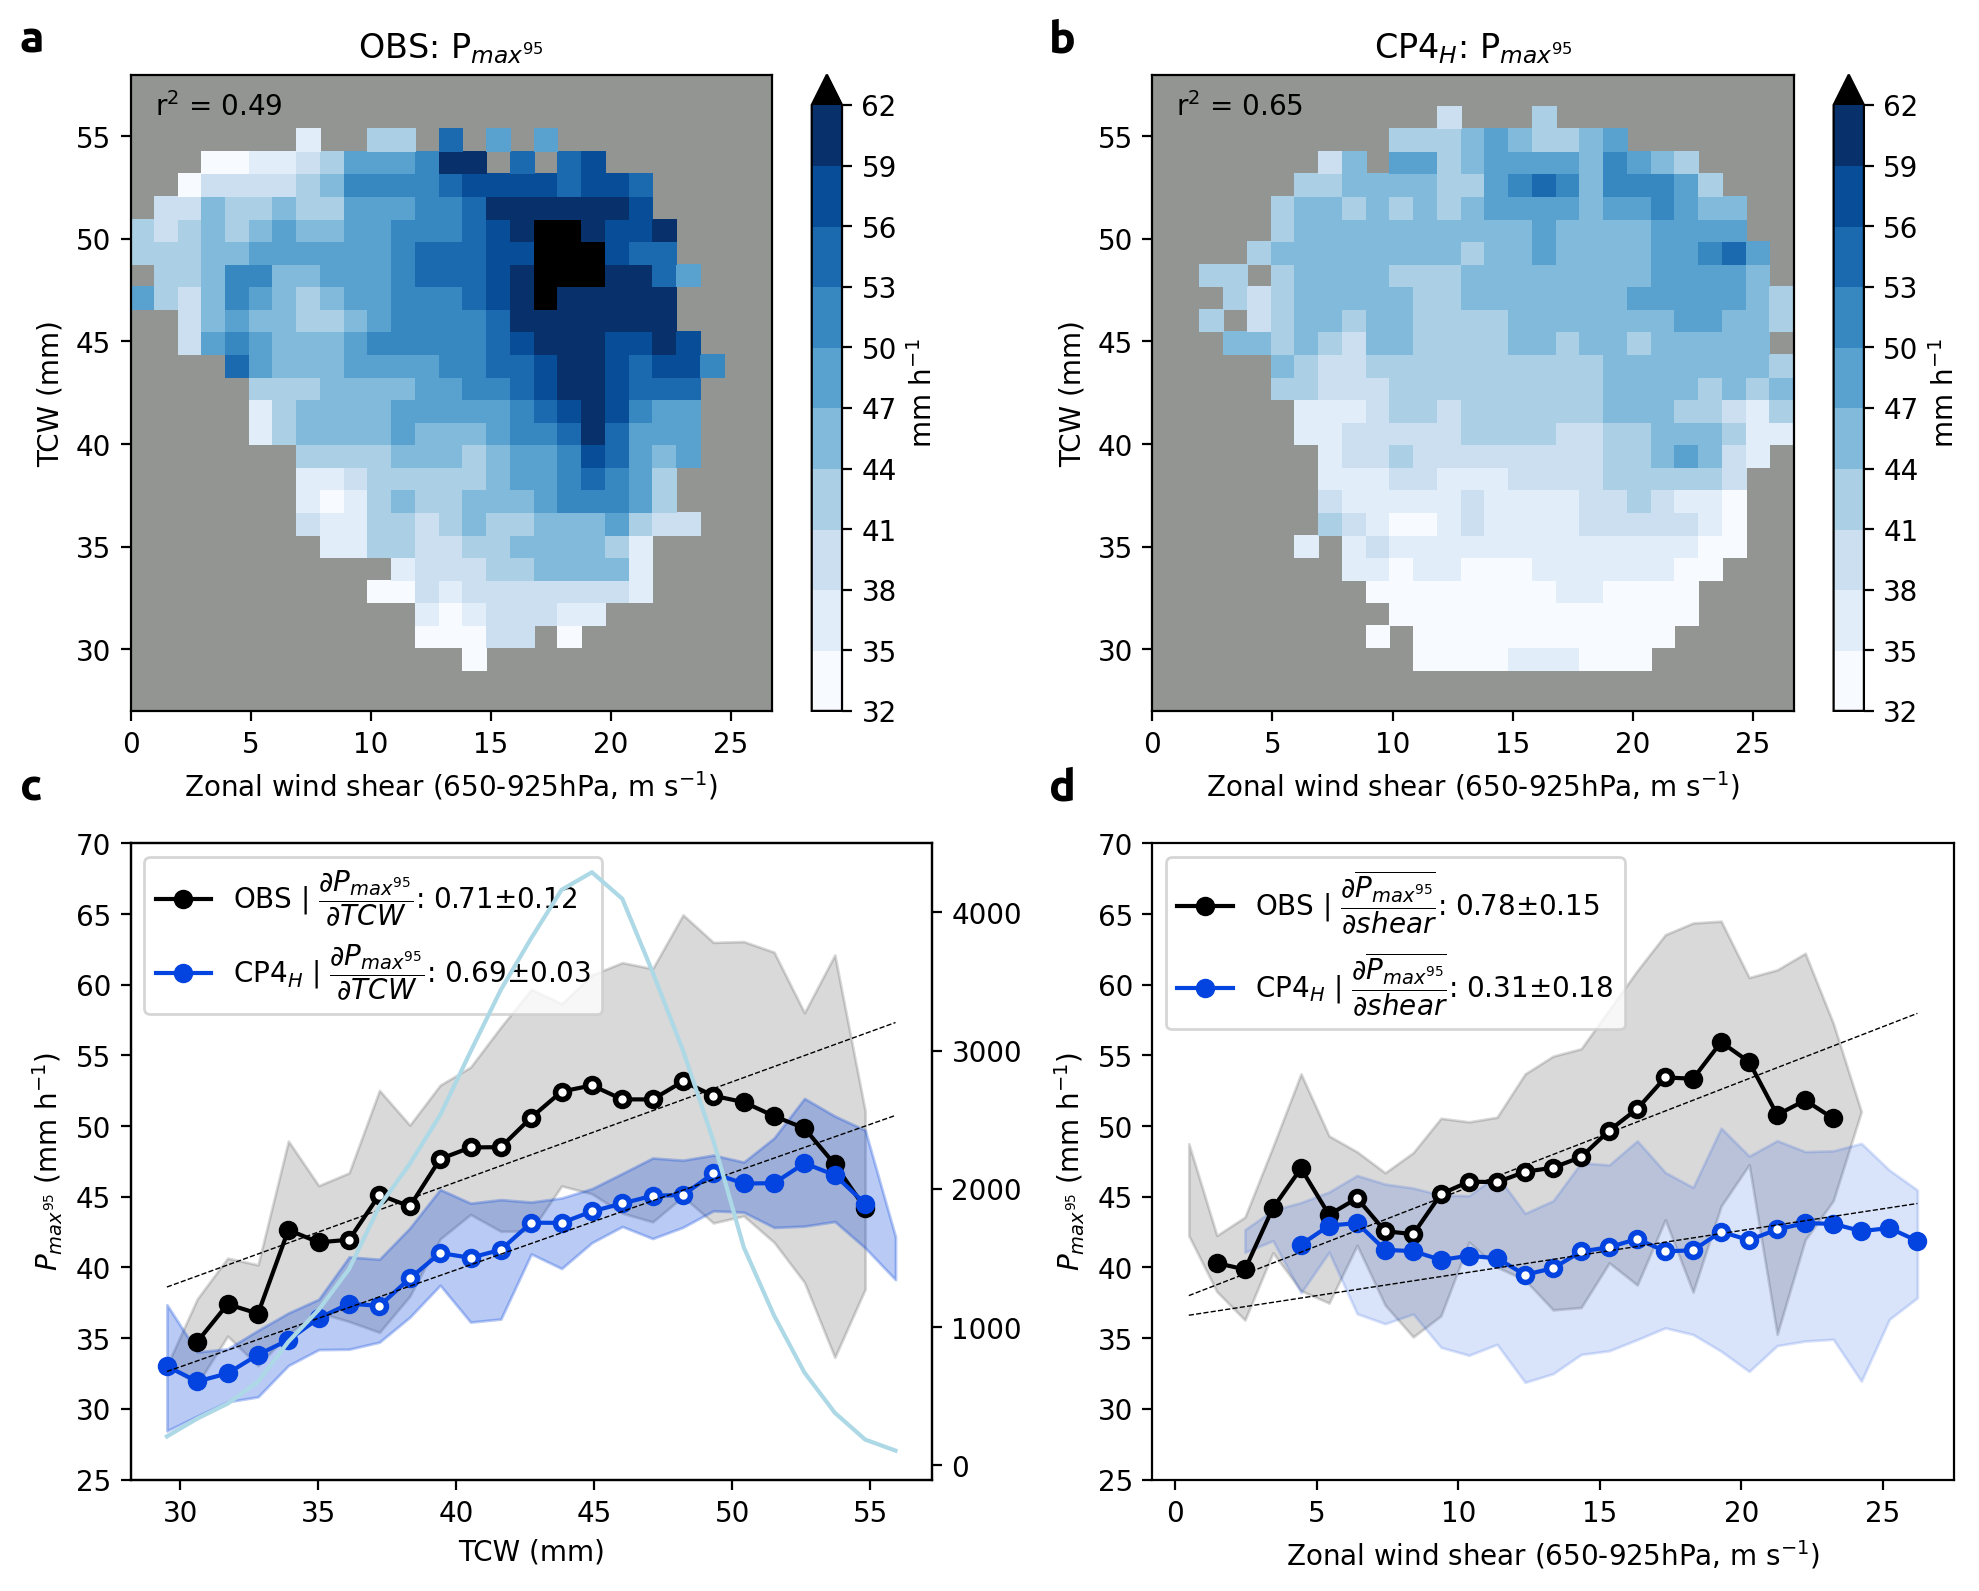

In [85]:
f = plt.figure(figsize=(10,8), dpi=200)
cmap='Blues'
vmins = 32
vmaxs = 62
pixelval = 10
cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
ax = f.add_subplot(2,2,1)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret.statistic.T, 0.8)
invalid = count.statistic.T < pixelval
dd[invalid] = np.nan
bigpos = np.where(dd>60)
print('bigpos', bigpos)
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
#plt.plot(testbins[0][bigpos[1]+1],testbins[1][bigpos[0]+1], 'o', color='grey', ms=1)
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dicobs['model'].rsquared,2)), fontsize=10)
plt.title('OBS: P$_{max^{95}}$')

cbar = plt.colorbar(mp, ticks=np.linspace(vmins, vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')

ax = f.add_subplot(2,2,2)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret4.statistic.T, 0.7)
invalid = count4.statistic.T < pixelval
dd[invalid] = np.nan
cmapp.set_over("black")
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
cbar = plt.colorbar(mp, ticks=np.linspace(vmins,vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dic4['model'].rsquared,2)), fontsize=10)
plt.title('CP4$_H$: P$_{max^{95}}$')

ax2 = f.add_subplot(223)

ax2.plot(tdicobs['bins'],tdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdicobs['slope'],2))+r'$\pm$'+str(np.round(tdicobs['model'].bse[1],2)))
ax2.fill_between(tdicobs['bins'],tdicobs['p10'],tdicobs['p90'], color='k', alpha=0.15)
ax2.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)
ax2.plot(tdic4['bins'],tdic4['pmean'], color='xkcd:blue', marker='o', label='CP4$_H$ | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdic4['slope'],2))+'$\pm$'+str(np.round(tdic4['model'].bse[1],2)))

indx = find_cumsum(frac_tcw, 0.8)
ax2.plot(tdicobs['bins'][indx-2],tdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
indx = find_cumsum(frac4_tcw, 0.8)
ax2.plot(tdic4['bins'][indx],tdic4['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')

#plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
ax2.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdicobs['bins'],(tdicobs['slope']-np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']-dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)
# plt.plot(tdicobs['bins'],(tdicobs['slope']+np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']+dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)

ax2.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)


ax2.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# ax22 = ax2.twinx()
# ax22.plot(tdic4['bins'], np.sum(count4.statistic.T,axis=1), color='lightblue')

# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']+tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)
# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']-tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)

# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']+tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']-tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
ax2.set_xlabel('TCW (mm)')
ax2.set_ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')


#plt.title('Zonal wind shear')
#plt.ylim(12,31)
#plt.ylim(15,33)
ax2.set_ylim(25,70)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.legend(loc='upper left')
# plt.text(50,28, r'SE$_{OBS} = $'+str(np.round(tdicobs['std_est'],2)), fontsize=10)
# plt.text(50,26, r'SE$_{CP4_H} = $'+str(np.round(tdic4['std_est'],2)), fontsize=10)




ax3 = f.add_subplot(224)
plt.plot(sdicobs['bins'],sdicobs['pmean'], '-ko', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdicobs['slope'],2))+'$\pm$'+str(np.round(sdicobs['model'].bse[1],2)))
plt.fill_between(sdicobs['bins'],sdicobs['p10'],sdicobs['p90'], color='k', alpha=0.15)
plt.fill_between(sdic4['bins'],sdic4['p10'],sdic4['p90'], color='xkcd:blue', alpha=0.15)

plt.plot(sdic4['bins'],sdic4['pmean'], color='xkcd:blue', marker='o', label=r'CP4$_{H}$ | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdic4['slope'],2))+'$\pm$'+str(np.round(sdic4['model'].bse[1],2)))
#plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)


plt.plot(sdic4['bins'],sdic4['slope']*sdic4['bins']+sdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

indx = find_cumsum(frac_shear, 0.8)
plt.plot(sdicobs['bins'][indx-2],sdicobs['pmean'][indx-2],marker='o', color='white', markersize=2, linestyle='')
indx = find_cumsum(frac4_shear, 0.8)
plt.plot(sdic4['bins'][indx],sdic4['pmean'][indx],marker='o', color='white', markersize=2, linestyle='')

fdic = {'obs_shear' : sdicobs['slope'], 'cp4_shear' : sdic4['slope'], 'SE' : sdicobs['model'].bse[1]}
import pickle
pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "wb"))

#plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')

plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')
#plt.title('Total column water vapour')
plt.legend(loc='upper left')
# plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[1],2)), fontsize=10)
# plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(dic4['model'].bse[1],2)), fontsize=10)
# plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[0],2)), fontsize=10)
# plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(sdic4['std_est'],2)), fontsize=10)
plt.tight_layout()
plt.ylim(25,70)
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(MultipleLocator(5))


text = ['a', 'b', 'c', 'd']
plt.annotate(text[0], xy=(0.01, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.53, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.01, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.53, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


#plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_NOFUTURE_50Cp90_duo_gauss_hourly2_8mm_new_modelR2.jpg')

bigpos (array([], dtype=int64), array([], dtype=int64))


Text(0, 4, 'd')

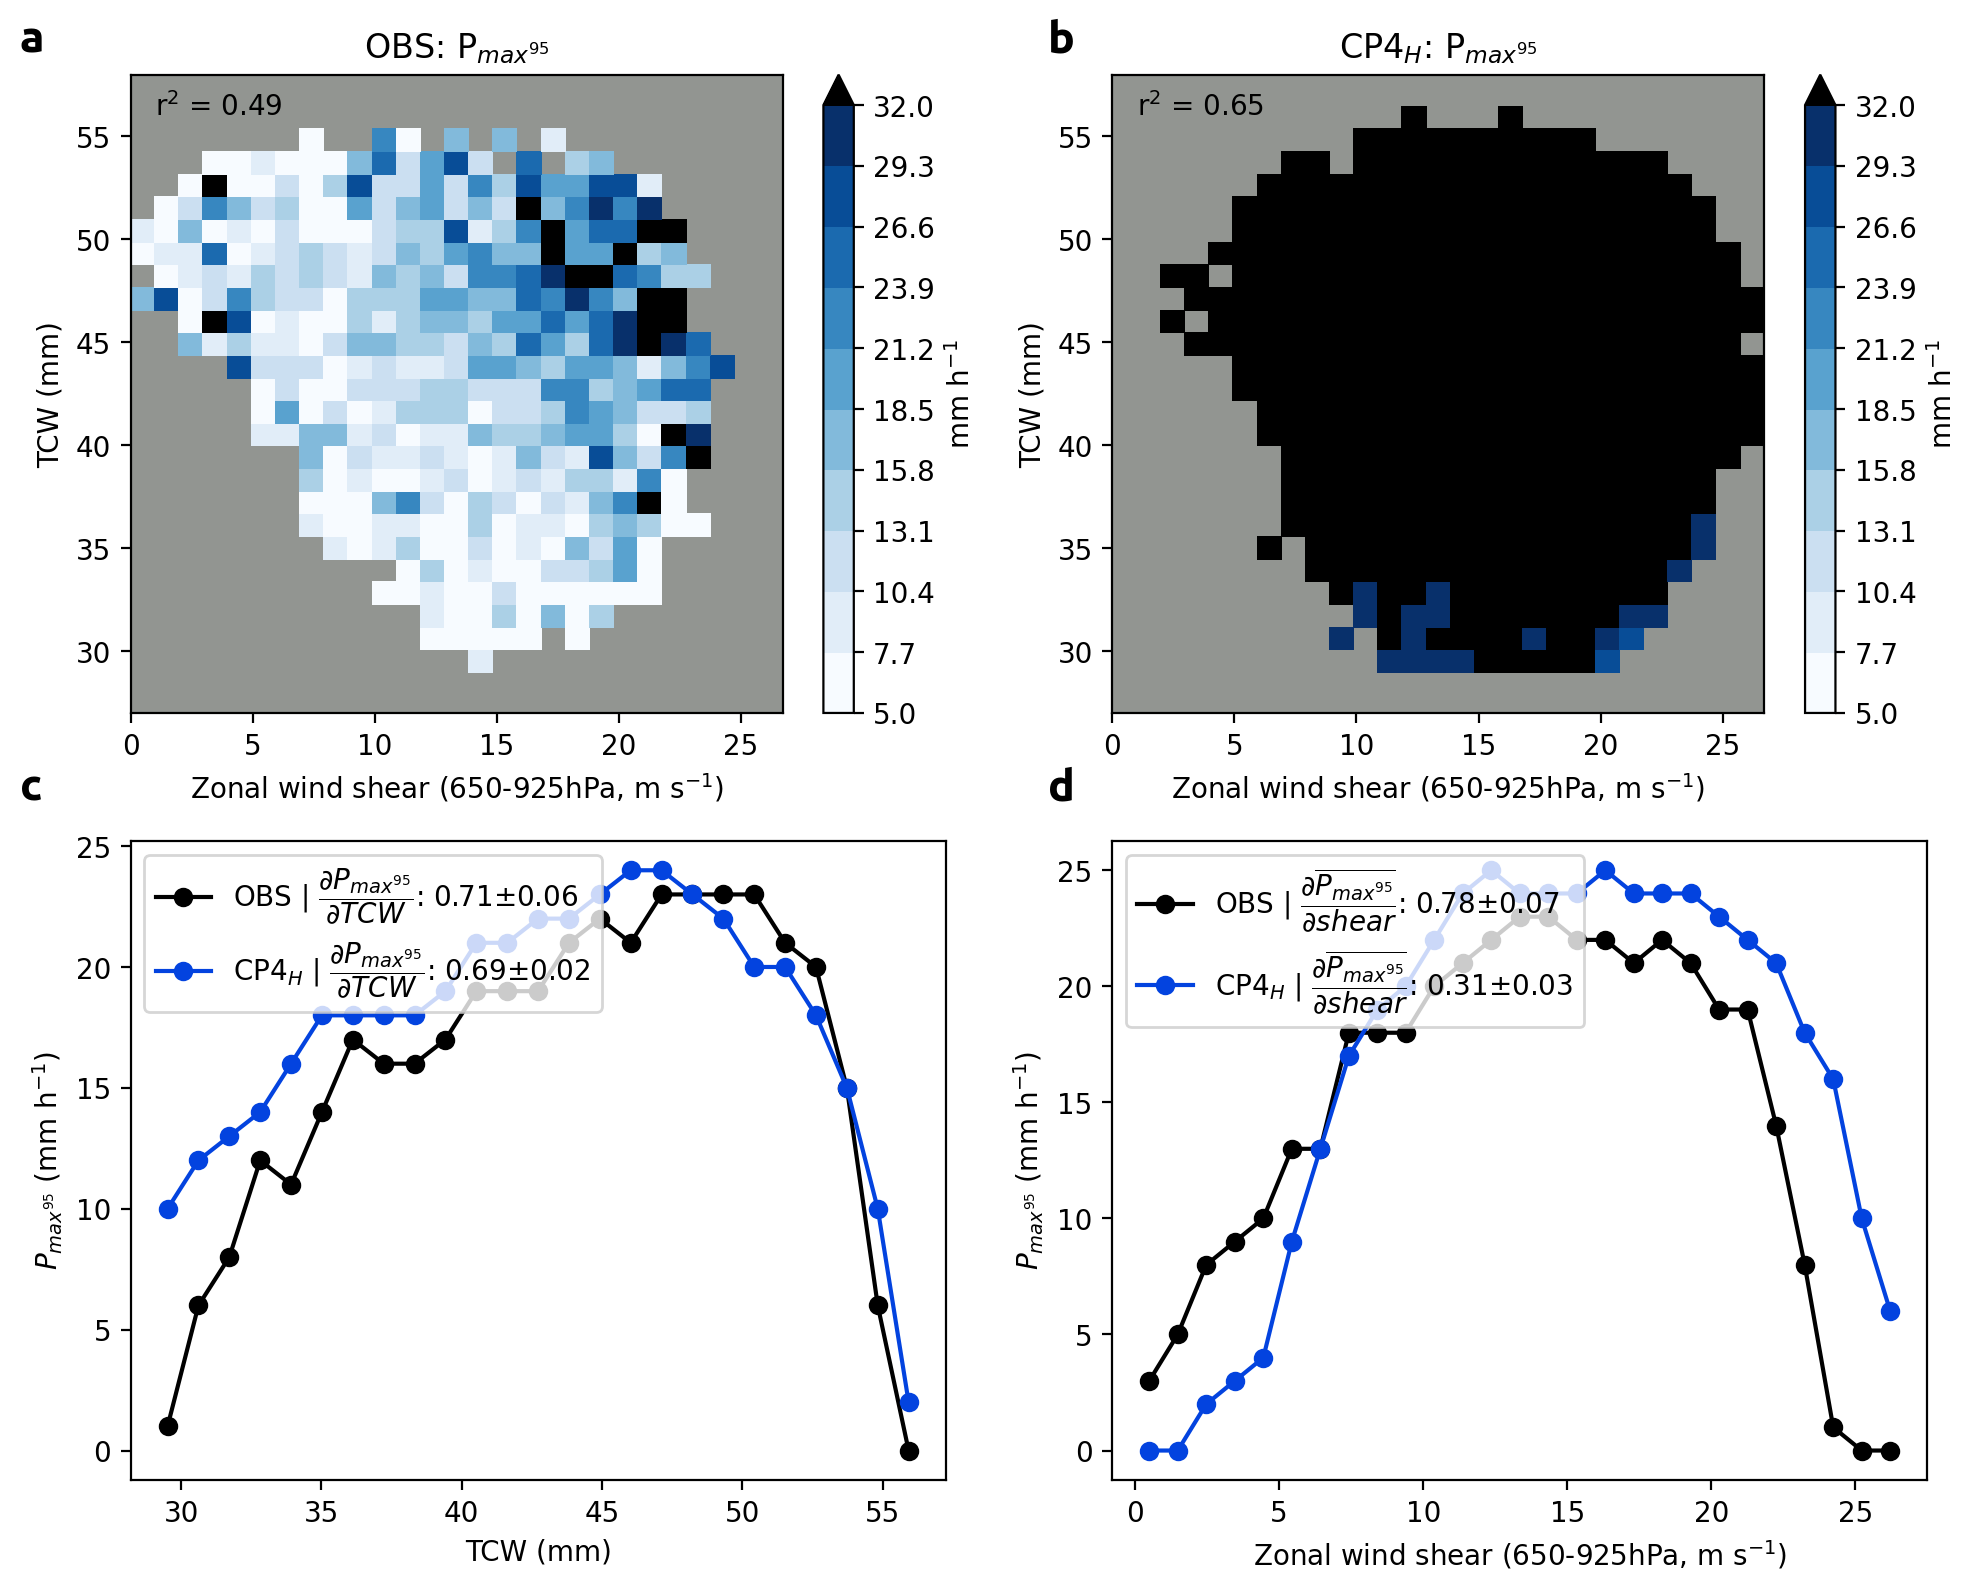

In [51]:
f = plt.figure(figsize=(10,8), dpi=200)
cmap='Blues'
vmins = 5
vmaxs = 32
pixelval = 10
cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
ax = f.add_subplot(2,2,1)
ax.set_facecolor('xkcd:grey')
dd = thresh.statistic.T
invalid = count.statistic.T < pixelval
dd[invalid] = np.nan


dd = dd/count.statistic.T*100
#dd = gauss(dd, 0.5)

bigpos = np.where(dd>60)
print('bigpos', bigpos)
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
#plt.plot(testbins[0][bigpos[1]+1],testbins[1][bigpos[0]+1], 'o', color='grey', ms=1)
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dicobs['model'].rsquared,2)), fontsize=10)
plt.title('OBS: P$_{max^{95}}$')

cbar = plt.colorbar(mp, ticks=np.linspace(vmins, vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')

ax = f.add_subplot(2,2,2)
ax.set_facecolor('xkcd:grey')
dd = gauss(ret4.statistic.T, 0.7)
invalid = count4.statistic.T < pixelval
dd[invalid] = np.nan
cmapp.set_over("black")
mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap=cmapp, vmin=vmins, vmax=vmaxs)
cbar = plt.colorbar(mp, ticks=np.linspace(vmins,vmaxs,11), extend='max')
cbar.set_label('mm h$^{-1}$')
ax.set_ylim(27,58)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('TCW (mm)')
plt.text(1,56, r'r$^2$ = '+str(np.round(dic4['model'].rsquared,2)), fontsize=10)
plt.title('CP4$_H$: P$_{max^{95}}$')

ax2 = f.add_subplot(223)
plt.plot(tdicobs['bins'],tdicobs['valid'], '-ko', label=r'OBS | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdicobs['slope'],2))+r'$\pm$'+str(np.round(dicobs['model'].bse[2],2)))
# plt.fill_between(tdicobs['bins'],tdicobs['p10'],tdicobs['p90'], color='k', alpha=0.15)
# plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)
plt.plot(tdic4['bins'],tdic4['valid'], color='xkcd:blue', marker='o', label='CP4$_H$ | $\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(tdic4['slope'],2))+'$\pm$'+str(np.round(dic4['model'].bse[2],2)))


#plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdicobs['bins'],(tdicobs['slope']-np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']-dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)
# plt.plot(tdicobs['bins'],(tdicobs['slope']+np.array(dicobs['model'].bse[2]))*tdicobs['bins']+tdicobs['intercept']+dicobs['model'].bse[0], linestyle='dashed', color='k', linewidth=0.5, alpha=0.15)

#plt.fill_between(tdic4['bins'],tdic4['p10'],tdic4['p90'], color='xkcd:blue', alpha=0.15)


#plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']+tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)
# plt.plot(tdicobs['bins'],tdicobs['slope']*tdicobs['bins']+tdicobs['intercept']-tdicobs['std_est']*2, linestyle='dotted', color='grey', linewidth=0.5)

# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']+tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
# plt.plot(tdic4['bins'],tdic4['slope']*tdic4['bins']+tdic4['intercept']-tdic4['std_est']*2, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('TCW (mm)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')


#plt.title('Zonal wind shear')
#plt.ylim(12,31)
#plt.ylim(15,33)
#plt.ylim(25,70)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(loc='upper left')
# plt.text(50,28, r'SE$_{OBS} = $'+str(np.round(tdicobs['std_est'],2)), fontsize=10)
# plt.text(50,26, r'SE$_{CP4_H} = $'+str(np.round(tdic4['std_est'],2)), fontsize=10)




ax3 = f.add_subplot(224)
plt.plot(sdicobs['bins'],sdicobs['valid'], '-ko', label=r'OBS | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdicobs['slope'],2))+'$\pm$'+str(np.round(dicobs['model'].bse[1],2)))
# plt.fill_between(sdicobs['bins'],sdicobs['p10'],sdicobs['p90'], color='k', alpha=0.15)
# plt.fill_between(sdic4['bins'],sdic4['p10'],sdic4['p90'], color='xkcd:blue', alpha=0.15)

plt.plot(sdic4['bins'],sdic4['valid'], color='xkcd:blue', marker='o', label=r'CP4$_{H}$ | $\dfrac{\partial \overline{P_{max^{95}}}}{\partial shear}$: ' + str(np.round(sdic4['slope'],2))+'$\pm$'+str(np.round(dic4['model'].bse[1],2)))
#plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
#plt.plot(sdicobs['bins'],sdicobs['slope']*sdicobs['bins']+sdicobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)


#plt.plot(sdic4['bins'],sdic4['slope']*sdic4['bins']+sdic4['intercept'], linestyle='dashed', color='k', linewidth=0.5)

fdic = {'obs_shear' : sdicobs['slope'], 'cp4_shear' : sdic4['slope']}
import pickle
pickle.dump(fdic, open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "wb"))

#plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')

plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('$P_{max^{95}}$ (mm h$^{-1}$)')
#plt.title('Total column water vapour')
plt.legend(loc='upper left')
# plt.text(21,28, r'SE$_{OBS} = $'+str(np.round(dicobs['model'].bse[0],2)), fontsize=10)
# plt.text(21,26, r'SE$_{CP4_H} = $'+str(np.round(sdic4['std_est'],2)), fontsize=10)
plt.tight_layout()
#plt.ylim(25,70)
ax3.xaxis.set_minor_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(MultipleLocator(5))


text = ['a', 'b', 'c', 'd']
plt.annotate(text[0], xy=(0.01, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.53, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.01, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.53, 0.49), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)


#plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_'+tag+'_15km_'+ttag+'_NOFUTURE_50Cp90_duo_gauss_hourly2_8mm_new.jpg')